# Here we want to analysis the full catalog

In [1]:
import pickle 

import matplotlib.pyplot as plt
import numpy as np
import obspy

import analysis
import catalog
import computations as cp
import histograms

catalog.display_params_for_catalog()

## Load the catalog

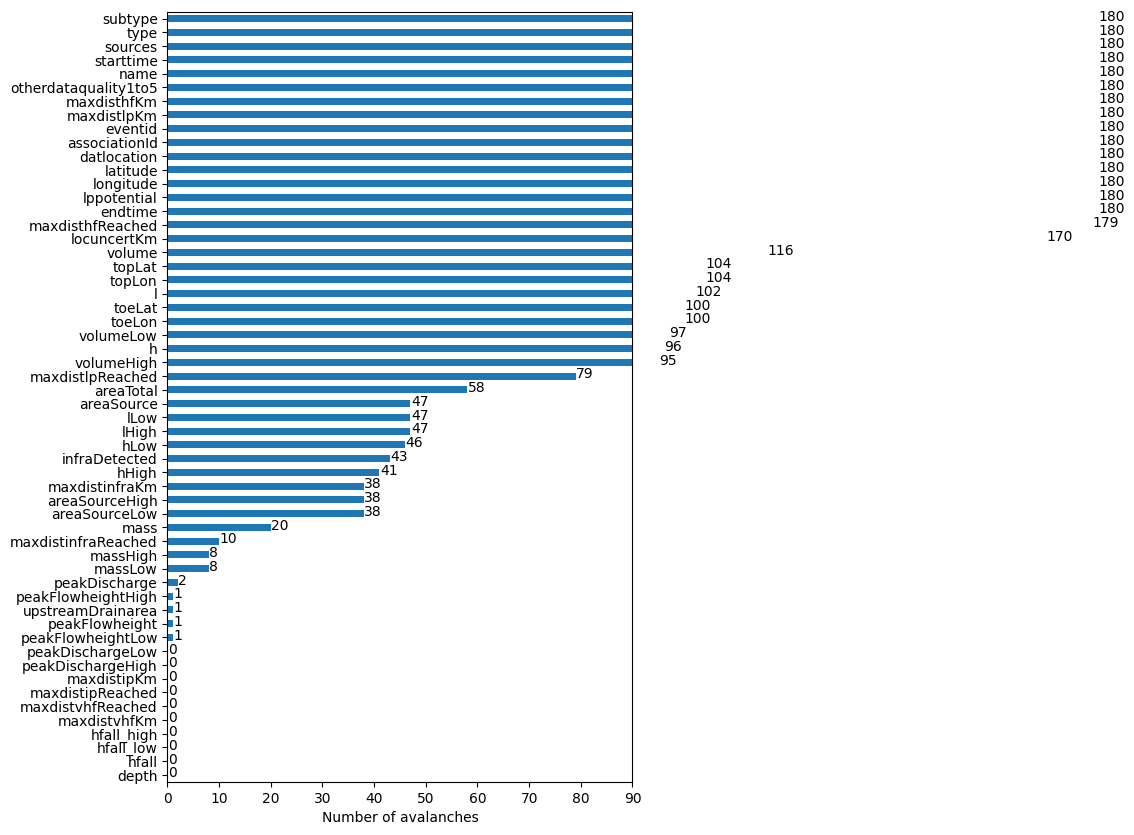

In [2]:
ESEC_avalanches = catalog.load("catalog/7_ESEC_avalanches_55.pickle")

histograms.open_catalog(ESEC_avalanches, pos_number=0.15, xlim=60)

In [3]:
event_index = 11

event = avalanches.iloc[event_index]
if pd.isna(event["volume"]):
    print("Pas de volume")
else:
    if event_index < 35:
        stream = obspy.read(f"/home/ceci/Documents/waveforms/{event_index:03d}.pickle", format="PICKLE")
        #stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")
        trace = stream[0]
        print(trace.stats.starttime)
        print(event["starttime"])
    else:
        if event_index < 115:
            stream = obspy.read(f"/home/ceci/Documents/waveforms/{event_index+1:03d}.pickle", format="PICKLE")
            #stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")
            trace = stream[0]
            print(trace.stats.starttime)
            print(event["starttime"])
        else:
            if event_index < 150:
                stream = obspy.read(f"/home/ceci/Documents/waveforms/{event_index+2:03d}.pickle", format="PICKLE")
                #stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")
                trace = stream[0]
                print(trace.stats.starttime)
                print(event["starttime"])
            else:
                stream = obspy.read(f"/home/ceci/Documents/waveforms/{event_index+3:03d}.pickle", format="PICKLE")
                #stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")
                trace = stream[0]
                print(trace.stats.starttime)
                print(event["starttime"])


NameError: name 'avalanches' is not defined

In [ ]:
stream2 = stream.copy().select(component="Z")
distance, closest_trace = cp.find_the_closest_trace_of_X_km(stream2, 0)
print(distance)



stream_filtered = stream.copy().select(component="Z")
stream_filtered.remove_response(output="DISP", pre_filt=(0.01, 0.02, 20, 25), water_level=60)
analysis.filtering(stream_filtered, freq_HP=9, freq_LP=0.5)

distance, closest_trace_filtered = cp.find_the_closest_trace_of_X_km(stream_filtered, 0)
print(distance)

In [ ]:
import scipy.stats
from scipy.signal import spectrogram

fig, ax = plt.subplots(3, 1, figsize=(15,9), constrained_layout=True)#, sharex=True, sharey=False)

#analysis.plot_trace(closest_trace, closest_trace.times().max(), ax=ax[0])
#ax[0].set_ylabel("Nombres numériques")

analysis.plot_trace(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[0])
ax[0].set_ylabel("Nombres numériques", fontsize=15)
analysis.plot_spectrogram(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[1])
ax[1].set_ylabel("Fréquence [Hz]", fontsize=15)

#Paramètres des traces





###########







avalanches = pickle.load(open("back-up/catalog_5_degres/avalanches_with_inventory_changes_incertainties.pickle", "rb"))
#avalanches

event_index = 11

event = avalanches.iloc[event_index]

stream = obspy.read(f"/home/ceci/Documents/waveforms/{event_index:03d}.pickle", format="PICKLE")






ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)

ax[1].set_xlim(0, 500)








###########



stream = stream.copy().select(component="Z")
stream.remove_response(output="DISP", pre_filt=(0.01, 0.02, 20, 25), water_level=60)
stream = analysis.filtering(stream, 9, 0.5)

stream = stream.sort(keys=["distance"]) #trier le stream en fonction de la distance
trace = stream[0]

energie_trace = []
temps_index_energie_trace = []

distance = trace.stats.distance
fs = trace.stats.sampling_rate
data = trace.data

#Calcul de l'énergie des traces
window_len = 20  # to modify according to the resolution needed at lower freq.
nperseg = int(window_len * fs)

frequencies, times, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=nperseg * 0.9, 
                                        nfft=analysis.next2pow(nperseg), scaling="density", mode="psd")

frequency_band = (0.1, 20) ########## freq high and low to modify
frequency_band_indices = np.where((frequencies > frequency_band[0]) & (frequencies < frequency_band[1]))[0]
energy = Sxx[frequency_band_indices, :].sum(axis=0)

#Calcul de la pente de l'énergie spectrale
energy_max = energy.max() #valeur maximale de l'énergie
energy_max_index = np.argmax(energy) #index
time_at_max_energy = times[energy_max_index] #index

energy_mean = energy.mean() / 4 #seuil pour sélectionner que la parabole de l'énergie
first_index = np.argmax(energy > energy_mean) #premier index de la ligne de détection
pente = (energy[energy_max_index] - energy[first_index]) / (time_at_max_energy - times[first_index]) #calcul pente


energy_above_energy_mean = energy > energy_mean
last_index = np.where(energy_above_energy_mean)[0][-1]

sub_times = times[first_index:last_index+1]
sub_energy = energy[first_index:last_index+1]

skewness = scipy.stats.skew(sub_energy)

energy_max = np.max(sub_energy)


energy_max_index = np.argmax(sub_energy)


# ax[2].plot(sub_times[energy_max_index], energy_max, 'rx', label="Maximum d'énergie")

ax[2].fill_between(times, energy, alpha=0.5)

#plt.plot(sub_times, sub_energy, label="distance " + str(np.round(distance)) + " km") #plot de l'énergie spectrale entière (JUSTE LA PARABOLE)
ax[2].plot(times, energy)#, label="distance " + str(np.round(distance)) + " km") #plot de l'énergie spectrale entière
# plt.plot(times[first_index], energy[first_index], 'gx') #plot du premier index de la ligne de détection sur l'énergie
# plt.plot(times[energy_above_energy_mean][-1], energy[energy_above_energy_mean][-1], 'rx') #plot du dernier index de la ligne de détection sur l'énergie
#plt.plot([times[first_index], time_at_max_energy], [energy[first_index], energy[energy_max_index]], 'r--') #plot de la pente

#calculer l'aire sous la courbe
aire = np.trapz(sub_energy, sub_times)

#plt.plot([temps_index_energie_trace[0], temps_index_energie_trace[-1]], [energie_trace[0], energie_trace[-1]])
#plt.xlim(100, 300)
energie_trace.append(energy_max)
temps_index_energie_trace.append(energy_max_index)

x1, y1 = sub_times[0], sub_energy[0]
x2, y2 = sub_times[energy_max_index], energy_max

pente_energy = (y2 - y1) / (x2 - x1)

#plot la pente
ax[2].plot([x1, x2], [y1, y2], 'r--', label="Impulsion")

long = np.linspace(0, len(stream)-1, len(stream))

# plt.ylim(0, 1.3e-10)
ax[2].set_xlabel("Temps [s]", fontsize=15)
ax[2].set_ylabel("Energie spectrale [V²/Hz]", fontsize=15)
ax[2].legend(fontsize=12)

#ax[3].set_xmargin(0)
ax[2].set_xlim(0, np.max(times))
#ax[3].legend(fontsize=9, bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.show()

ax[0].tick_params(axis='y', labelsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].tick_params(axis='x', labelsize=15)

ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)

#cacher les xticks et label de la figure 1
#ax[1].set_xticks([])
ax[1].set_xticklabels([])
ax[1].set_xlabel("")

"""
letter_labels = ['A', 'B', 'C']#, 'D', 'E']
for k, axs in enumerate(ax.flat):
    axs.text(0.02, 0.98, letter_labels[k], transform=axs.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')
"""

plt.subplots_adjust()
plt.savefig("figures/trace_spectrogram.pdf", dpi=800)

In [ ]:
import scipy.stats
from scipy.signal import spectrogram

fig, ax = plt.subplots(3, 1, figsize=(15,11), constrained_layout=True, gridspec_kw=dict(height_ratios=[1, 1, 2]))# sharex=True, sharey=False)

analysis.plot_trace(closest_trace, closest_trace.times().max(), ax=ax[0])
ax[0].set_ylabel("Nombres numériques", fontsize=12)

#analysis.plot_trace(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[1])
#analysis.plot_spectrogram(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[3])

#Paramètres des traces





###########




"""
analysis.plot_trace(closest_trace, closest_trace.times().max(), ax=ax[0])
ax[0].set_ylabel("Nombres numériques", fontsize=9.5)

analysis.plot_trace(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[1])
analysis.plot_spectrogram(closest_trace_filtered, closest_trace_filtered.times().max(), ax=ax[2])
"""

avalanches = pickle.load(open("back-up/catalog_5_degres/avalanches_with_inventory_changes_incertainties.pickle", "rb"))
#avalanches

event_index = 11

event = avalanches.iloc[event_index]

stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")

# Filter the data
stream_filtered = stream.copy().select(component="Z")
stream_filtered.remove_response(output="DISP", pre_filt=(0.01, 0.02, 20, 25), water_level=60)
analysis.filtering(stream_filtered, freq_HP=9, freq_LP=0.5)

stream_filtered = stream_filtered.sort(keys=["distance"], reverse=False)

trace = stream_filtered[0]
distance = trace.stats.distance
print(distance)

time_raw = trace.times()
data_raw = trace.data

wavespeed = 6.5

start_time_event_shifted = computation.conversion_du_temps_du_catalogue(trace, avalanches["starttime"][event_index])
end_time_event_shifted = computation.conversion_du_temps_du_catalogue_endtime(trace, avalanches["endtime"][event_index])

intersection_time = distance / wavespeed + start_time_event_shifted
intersection_time_end = distance / wavespeed + end_time_event_shifted

start_time = intersection_time
end_time = intersection_time_end

mask = (time_raw >= start_time) & (time_raw <= end_time)

time_start_detection = time_raw[mask]
data_start_detection = trace.data[mask]

time_bruit, data_bruit = computation.selectionner_les_50_premieres_secondes_de_la_trace(trace)

time, data, threshold_2, data_abs_median, data_above_threshold_1, data_above_threshold_2, threshold_1 = analysis.get_2_thresholds_new_version_demo(time_start_detection, data_start_detection, time_bruit, data_bruit)

# try:
ax[1].plot(time_raw, data_raw, lw=0.5)
# Get the indices of the start and end times
start_idx = np.where(time_raw == time[data_above_threshold_2][0])[0][0]
end_idx = np.where(time_raw == time[data_above_threshold_1][-1])[0][0]

# Select the portion of the arrays between these indices
time_raw_trimmed = time_raw[start_idx:end_idx+1]
data_raw_trimmed = data_raw[start_idx:end_idx+1]
ax[1].plot(time_raw_trimmed, data_raw_trimmed, "C1", lw=0.5, label="Signal sismique détecté")

# ax.plot(time[data_above_threshold_2], data[data_above_threshold_2], "r.")
# ax.plot(time[data_above_threshold_1], data[data_above_threshold_1], "g.")

ax[1].plot(time[data_above_threshold_1][-1], data[data_above_threshold_1][-1], "gx", markersize=10, markeredgewidth=2)
ax[1].plot(time[data_above_threshold_2][0], data[data_above_threshold_2][0], "rx", markersize=10, markeredgewidth=2)

ax[1].axhline(threshold_1, color="g", label="Seuil du signal", linestyle="--")
ax[1].axhline(threshold_2, color="r", label="Seuil du bruit", linestyle="--")



ax[1].legend(loc='upper right', fontsize=11)
ax[1].set_xlabel("Temps [s]", fontsize=12)
ax[1].set_ylabel("Déplacement [m]", fontsize=12)

# ax[2].set_xlim(100, 500)
# ax[2].set_xmargins(x=0)
# plt.savefig("explication_methode_dectection1")
#     plt.show()

# except TypeError:
#     print("Pas de détection")


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

event_index = 11

event = avalanches.iloc[event_index]

stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")
#stream = obspy.read(f"D:/sismoavalanche/stageM2/waveforms/{event_index:03d}.pickle", format="PICKLE")


stream = stream.copy().select(component="Z")
trace = stream[0]
trace.remove_response(output="DISP", pre_filt=(0.01, 0.02, 20, 25), water_level=60)
analysis.filtering(trace, freq_HP=9, freq_LP=0.5)

#Paramètres de la trace
distance = trace.stats.distance
time = trace.times()
time_max = trace.times().max()


start_time_event_shifted = cp.conversion_du_temps_du_catalogue(trace, event["starttime"])
end_time_event_shifted = cp.conversion_du_temps_du_catalogue_endtime(trace, event["endtime"])


wavespeed = 6.5
intersection_time = distance / wavespeed + start_time_event_shifted
intersection_time_end = distance / wavespeed + end_time_event_shifted

#Définir les seuils du signal et du bruit
time_bruit, data_bruit = cp.selectionner_les_50_premieres_secondes_de_la_trace(trace)
trimmed_time, trimmed_data, start_time, end_time = analysis.detection_ultime(trace, start_time_event_shifted, intersection_time_end, time_bruit, data_bruit)

#Welch
segment_duration = 20
noverlap = 12

nperseg = int(segment_duration * trace.stats.sampling_rate)

frequencies_signal, psd_signal = welch(trimmed_data, fs=trace.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)
distance = trace.stats.distance



def equation(f, fc, alpha):
    A0 = np.mean(psd_signal[:3])
    return np.log(A0 / (1 + (f/fc) ** alpha))


mask = (frequencies_signal > 0.5) & (frequencies_signal < 9)
frequencies_signal = frequencies_signal[mask]
psd_signal = psd_signal[mask]

popt, pcov = curve_fit(equation, frequencies_signal, np.log(psd_signal), maxfev=2000)

ax[2].loglog(frequencies_signal, psd_signal, color="C1", label="Spectre du signal sismique détecté")
ax[2].loglog(frequencies_signal, np.exp(equation(frequencies_signal, *popt)), 'black', linestyle='--', label='Modèle')
ax[2].axhline(np.mean(psd_signal[:3]), color='C4', label=r'Amplitude A$_0$')
ax[2].axvline(popt[0], color='teal', label=r'Fréquence coin f$_c$')
ax[2].set_xlabel('Fréquences [Hz]', fontsize=12)
ax[2].set_ylabel(r'DSP de déplacement [$\mathrm{\frac{m^{2}}{Hz}}$]', fontsize=12)
ax[2].legend(loc='upper right', fontsize=11, framealpha=1)
ax[2].margins(x=0)

"""
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)
"""
ax[1].set_xlim(0, 500)








###########



stream = stream.copy().select(component="Z")
stream.remove_response(output="DISP", pre_filt=(0.01, 0.02, 20, 25), water_level=60)
stream = analysis.filtering(stream, 9, 0.5)

stream = stream.sort(keys=["distance"]) #trier le stream en fonction de la distance
trace = stream[0]

energie_trace = []
temps_index_energie_trace = []

distance = trace.stats.distance
fs = trace.stats.sampling_rate
data = trace.data

#Calcul de l'énergie des traces
window_len = 20  # to modify according to the resolution needed at lower freq.
nperseg = int(window_len * fs)

frequencies, times, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=nperseg * 0.9, 
                                        nfft=analysis.next2pow(nperseg), scaling="density", mode="psd")

frequency_band = (0.1, 2) ########## freq high and low to modify
frequency_band_indices = np.where((frequencies > frequency_band[0]) & (frequencies < frequency_band[1]))[0]
energy = Sxx[frequency_band_indices, :].sum(axis=0)

#Calcul de la pente de l'énergie spectrale
energy_max = energy.max() #valeur maximale de l'énergie
energy_max_index = np.argmax(energy) #index
time_at_max_energy = times[energy_max_index] #index

energy_mean = energy.mean() / 4 #seuil pour sélectionner que la parabole de l'énergie
first_index = np.argmax(energy > energy_mean) #premier index de la ligne de détection
pente = (energy[energy_max_index] - energy[first_index]) / (time_at_max_energy - times[first_index]) #calcul pente


energy_above_energy_mean = energy > energy_mean
last_index = np.where(energy_above_energy_mean)[0][-1]

sub_times = times[first_index:last_index+1]
sub_energy = energy[first_index:last_index+1]

skewness = scipy.stats.skew(sub_energy)

energy_max = np.max(sub_energy)


energy_max_index = np.argmax(sub_energy)


#ax[4].plot(sub_times[energy_max_index], energy_max, 'rx')

#ax[4].fill_between(times, energy)

#plt.plot(sub_times, sub_energy, label="distance " + str(np.round(distance)) + " km") #plot de l'énergie spectrale entière (JUSTE LA PARABOLE)
#ax[4].plot(times, energy, label="distance " + str(np.round(distance)) + " km", alpha=0.7) #plot de l'énergie spectrale entière
# plt.plot(times[first_index], energy[first_index], 'gx') #plot du premier index de la ligne de détection sur l'énergie
# plt.plot(times[energy_above_energy_mean][-1], energy[energy_above_energy_mean][-1], 'rx') #plot du dernier index de la ligne de détection sur l'énergie
#plt.plot([times[first_index], time_at_max_energy], [energy[first_index], energy[energy_max_index]], 'r--') #plot de la pente

#calculer l'aire sous la courbe
aire = np.trapz(sub_energy, sub_times)

#plt.plot([temps_index_energie_trace[0], temps_index_energie_trace[-1]], [energie_trace[0], energie_trace[-1]])
#plt.xlim(100, 300)
energie_trace.append(energy_max)
temps_index_energie_trace.append(energy_max_index)

x1, y1 = sub_times[0], sub_energy[0]
x2, y2 = sub_times[energy_max_index], energy_max

pente_energy = (y2 - y1) / (x2 - x1)

#plot la pente
#[4].plot([x1, x2], [y1, y2], 'r--')

long = np.linspace(0, len(stream)-1, len(stream))

# plt.ylim(0, 1.3e-10)
#ax[4].set_xlabel("Temps [s]")
#ax[4].set_ylabel("Energie spectrale [V²/Hz]")
#ax[3].set_xmargin(0)
#ax[4].set_xlim(0, np.max(times))
#ax[3].legend(fontsize=9, bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.show()


ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
#ax[2].set_xlim(0, time_max)
#ax[3].set_xlim(0, 500)
#ax[4].set_xlim(0, 500)

import matplotlib.ticker as ticker

ax[2].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax[0].tick_params(axis='y', labelsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].tick_params(axis='x', labelsize=15)

"""
letter_labels = ['A', 'B', 'C']#, 'D', 'E']
for k, axs in enumerate(ax.flat):
    axs.text(0.015, 0.11, letter_labels[k], transform=axs.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='right')
"""

plt.subplots_adjust()
plt.savefig("figures/trace_spectrogram_enveloppe_news_brut.pdf", dpi=800)